Importing the libraries to perform the classification

In [13]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import seaborn as sns


Loading the directory where the images are stored

In [2]:
PATH =os.getcwd()+'/COVID-19_Radiography_Dataset'

In [3]:
os.listdir(PATH)

['.DS_Store', 'Viral Pneumonia', 'Lung_Opacity', 'Normal', 'COVID']

Creating our datasets for the purpose of analysis

In [4]:
# Image generator for training (includes data augmentation)
imgTrainGen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True, #Set each sample mean to 0.
    samplewise_std_normalization= True, # Divide each input by its standard deviation]
    rescale=1./255, 
    zoom_range = 0.2, 
    validation_split = 0.2  
)

# Image generator for Validation (didn't include augmentation)
imgValidGen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True, #Set each sample mean to 0.
    samplewise_std_normalization= True,
    rescale=1./255,
    validation_split = 0.2
)

# Image generator for testing (didn't include augmentation)
imgTestGen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.2
)
# Build for training
trainGeneratorBuild = imgTrainGen.flow_from_directory(
    PATH,
    subset = 'training',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle= True
)
# Build for validation
validGeneratorBuild = imgValidGen.flow_from_directory(
    PATH,
    subset = 'validation',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle=True
)
# Build for testing
testGeneratorBuild = imgTestGen.flow_from_directory(
    PATH,
    subset = 'validation',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle=True
)

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


Exploratory Data Analysis

In [5]:
class_names = trainGeneratorBuild .class_indices
print(class_names)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [6]:
classes = list(class_names.keys())
print(classes)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [7]:
images, labels = next(trainGeneratorBuild)
labels = np.argmax(labels, axis=1)
class_dict = trainGeneratorBuild.class_indices
class_dict_inv = dict((v, k) for k, v in class_dict.items())
y_names = [class_dict_inv[key] for key in labels]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

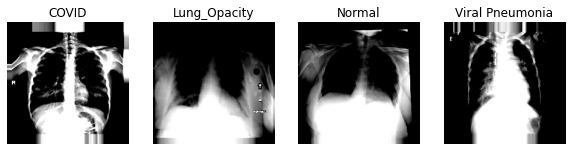

In [8]:
plt.figure(figsize=(10, 10))
for image in images:
    j = 0
    for i in range(4):
        ax = plt.subplot(1, 4, i+1)
        for k in range(len(labels)):
            if labels[k] == j:
                plt.imshow(images[k])
                plt.title(classes[i])
                plt.axis("off")
                break
        j = j+1


In [9]:
all_items, dirs, files = next(os.walk(PATH))


In [10]:
image_in_classes = []
for i in range(len(dirs)):
    no_of_images = len(os.listdir(os.path.join(PATH, dirs[i])))
    image_in_classes.append(no_of_images)
df_data = {'class': dirs, 'counts': image_in_classes}
classes_df = pd.DataFrame(df_data)


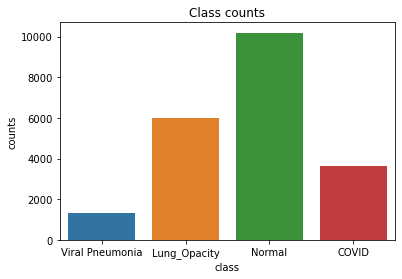

In [11]:
sns.barplot(x='class', y='counts', data=classes_df)
plt.title('Class counts')
plt.show()


Creating our custom CNN model for training the Covid-19 Radiography dataset

In [14]:
#using the keras api's to build our Convolutional Neural Network Model
print("----Building the model----")
i = Input(shape=(224, 224, 3))  # defining input
x = BatchNormalization()(i)
x = Conv2D(16, 3, activation='relu')(i)  # adding convolution layers
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Conv2D(32, 3, activation='relu')(i)  # adding convolution layers
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Conv2D(128, 3, activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(4, activation='softmax')(x)

model = Model(i, x)
model.summary()



----Building the model----
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',
                           patience=5,
                           restore_best_weights=True)


In [18]:
mc = ModelCheckpoint('cnn_model.h5', monitor='val_loss',
                     mode='min', verbose=1, save_best_only=True)


In [19]:

history = model.fit(trainGeneratorBuild, batch_size=32, epochs=10,
                    validation_data=validGeneratorBuild, callbacks=[early_stop, mc], verbose=1)


2021-11-19 10:33:24.229654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-19 10:33:24.230991: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2021-11-19 10:33:24.599072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


530/530 [==============================] - ETA: 0s - loss: 0.8723 - accuracy: 0.6787

2021-11-19 10:38:09.079169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


530/530 [==============================] - 321s 601ms/step - loss: 0.8723 - accuracy: 0.6787 - val_loss: 0.5990 - val_accuracy: 0.7696

Epoch 00001: val_loss improved from inf to 0.59904, saving model to cnn_model.h5
Epoch 2/10
530/530 [==============================] - 318s 599ms/step - loss: 0.6011 - accuracy: 0.7646 - val_loss: 0.5023 - val_accuracy: 0.8017

Epoch 00002: val_loss improved from 0.59904 to 0.50229, saving model to cnn_model.h5
Epoch 3/10
530/530 [==============================] - 317s 598ms/step - loss: 0.5074 - accuracy: 0.8052 - val_loss: 0.3940 - val_accuracy: 0.8526

Epoch 00003: val_loss improved from 0.50229 to 0.39395, saving model to cnn_model.h5
Epoch 4/10
530/530 [==============================] - 318s 599ms/step - loss: 0.4611 - accuracy: 0.8229 - val_loss: 0.3790 - val_accuracy: 0.8592

Epoch 00004: val_loss improved from 0.39395 to 0.37900, saving model to cnn_model.h5
Epoch 5/10
530/530 [==============================] - 318s 600ms/step - loss: 0.4172 - 

In [20]:
print("Train score:", model.evaluate(trainGeneratorBuild))
print("Validation score:", model.evaluate(validGeneratorBuild))
n_epochs = len(history.history['loss'])


530/530 [==============================] - 147s 276ms/step - loss: 0.2498 - accuracy: 0.9070
Train score: [0.24979765713214874, 0.9069863557815552]
133/133 [==============================] - 37s 275ms/step - loss: 0.2859 - accuracy: 0.8970
Validation score: [0.2859458923339844, 0.8969754576683044]


Plotting the curve

In [22]:
def plotLearningCurve(history, epochs):
  epochRange = range(1, epochs+1)
  fig, ax = plt.subplots(1, 2, figsize=(20, 10))
  ax[0].plot(epochRange, history.history['accuracy'],
             'b', label='Training Accuracy')
  ax[0].plot(epochRange, history.history['val_accuracy'],
             'r', label='Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize=20)
  ax[0].set_ylabel('Accuracy', fontsize=20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange, history.history['loss'], 'b', label='Training Loss')
  ax[1].plot(epochRange, history.history['val_loss'],
             'r', label='Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize=20)
  ax[1].set_ylabel('Loss', fontsize=20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()


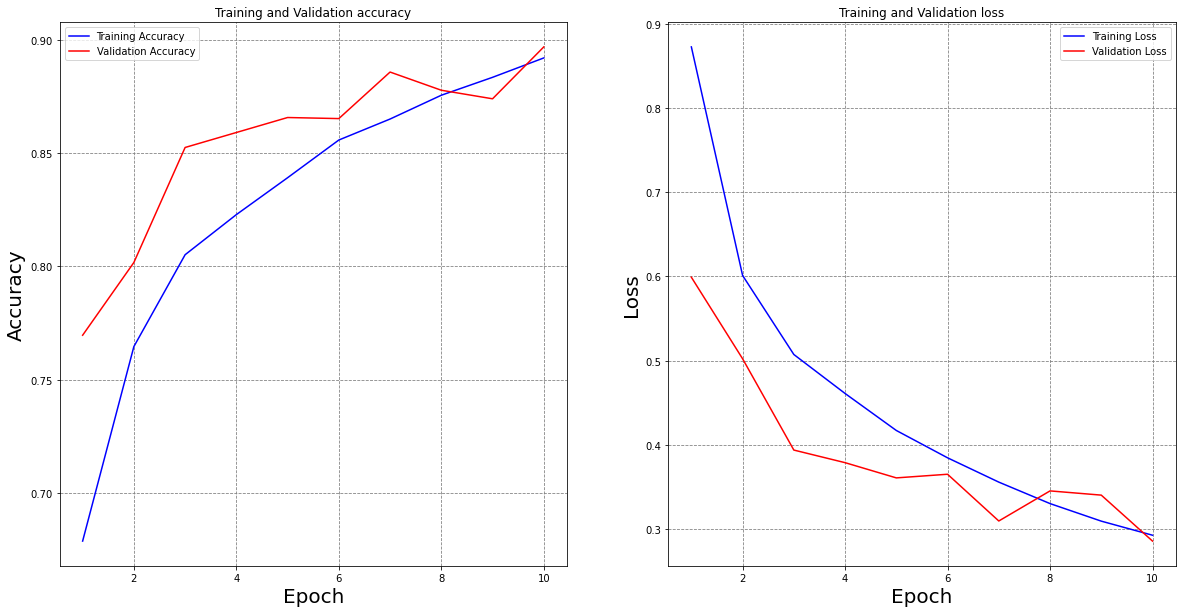

In [23]:
plotLearningCurve(history, n_epochs)


In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [25]:
Y_pred = model.predict_generator(testGeneratorBuild)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
confusion_matrix = confusion_matrix(testGeneratorBuild.classes, y_pred)
print(confusion_matrix)
print('Classification Report')
target_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
print(classification_report(testGeneratorBuild.classes,
      y_pred, target_names=target_names))


/Users/aqdus/miniforge3/envs/mlp/lib/python3.9/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
2021-11-19 11:54:59.337731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Confusion Matrix
[[ 694   12    2   15]
 [1150   21    9   22]
 [1955   28   17   38]
 [ 260    4    1    4]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.17      0.96      0.29       723
   Lung_Opacity       0.32      0.02      0.03      1202
         Normal       0.59      0.01      0.02      2038
Viral Pneumonia       0.05      0.01      0.02       269

       accuracy                           0.17      4232
      macro avg       0.28      0.25      0.09      4232
   weighted avg       0.41      0.17      0.07      4232



Testing our model

In [26]:
from tensorflow.keras.preprocessing import image


def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224, 224, 3))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)

  return img


2021-11-19 11:55:48.205606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


The given X-Ray image is of type = COVID

The chances of image being Covid is : 100.0 percent

The chances of image being Lung_Opacity is : 0.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral Pneumonia is : 0.0 percent


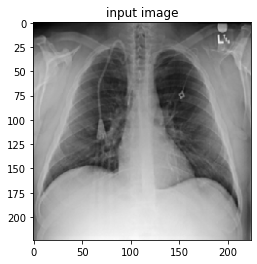

In [27]:
# path for that new image.
PATH = os.getcwd()+'/COVID-19_Radiography_Dataset/Normal/Normal-5.png'
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
# you can add any image path
img = get_img_array(PATH)

res = class_names[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(
    f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(
    f"The chances of image being Lung_Opacity is : {model.predict(img)[0][1]*100} percent")
print()
print(
    f"The chances of image being Normal is : {model.predict(img)[0][2]*100} percent")
print()
print(
    f"The chances of image being Viral Pneumonia is : {model.predict(img)[0][3]*100} percent")


# to display the image
plt.imshow(img[0]/255, cmap="gray")
plt.title("input image")
plt.show()
